In [1]:
import numpy as np
import mygrad as mg
from mygrad import Tensor

from noggin import create_plot
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from cogworks_data.language import get_data_path

from pathlib import Path
import json

# load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)

In [4]:
captions = coco_data["annotations"]

In [5]:
# load saved image descriptor vectors
import pickle
with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
    resnet18_features = pickle.load(f)

In [6]:
from gensim.models import KeyedVectors
filename = "glove.6B.200d.txt.w2v"

# this takes a while to load -- keep this in mind when designing your capstone project
glove = KeyedVectors.load_word2vec_format(get_data_path(filename), binary=False)

In [7]:
image_IDs = [i["id"] for i in coco_data["images"]]
caption_IDs = [i["id"] for i in coco_data["annotations"]]

In [8]:
#Dictionary 1:
#image-ID -> [cap-ID-1, cap-ID-2, ...]


img2captions = {}

for cap in coco_data["annotations"]:
    if cap["image_id"] not in img2captions:
        img2captions[cap["image_id"]] = []
    img2captions[cap["image_id"]].append(cap["id"])

In [9]:
#Dictionary 2:
#caption-ID -> image-ID

cap2img = {}

for caption in coco_data["annotations"]:
    cap2img[caption["id"]] = caption["image_id"]

In [10]:
#Dictionary 3:
#caption-ID -> caption (e.g. 24 -> "two dogs on the grass")

capID2cap = {}

for caption in captions:
    capID2cap[caption["id"]] = caption["caption"]

In [32]:
import re, string
from collections import Counter

punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

def strip_punc(corpus):
    return punc_regex.sub('', corpus)
    
def clean_phrase (line):
    strip_punc(line)
    line = line.lower()
    arr = line.split()
    return arr

def get_IDF(word):
    count = 0
    counter = Counter() 
    for cap in captions :
        cap = cap["caption"]
        clean = set(clean_phrase(cap))
        counter.update(Counter(clean))
        
    return np.log10( (len(captions) / counter[word] ) )

def get_gloveE(caption): 
    return glove[caption]

def get_word_vectors(line):
    strip_punc(line)
    line = line.lower()
    arr = line.split()
    verctor_sum = 0
    for word in arr:
        verctor_sum += (get_IDF(word) * get_gloveE(word))
    return verctor_sum

In [20]:
def datasplit(X):
  X_train, X_test = train_test_split(X, train_size=0.8, random_state=50)
  return (X_train, X_test)

In [13]:
np.random.choice([1,2,3], size=10)

array([1, 3, 3, 3, 1, 3, 2, 3, 1, 1])

In [25]:
def generateTriples(imglist, img2captions):
    ret = []
    
    
    fake_list = np.random.choice(imglist, size=1_000_000)

    counter = 0
    for img in imglist:
        if (counter % 10000 == 0) : print(counter)
        for caption in img2captions[img]:
            caption = get_word_vectors(capID2cap[caption])
            
            counter+=1
            fake= fake_list[counter]
            while (fake == img):
                counter+=1
                fake = fake_list[counter]
            ret.append((caption, img, fake))
    return ret

In [ ]:
train, test = datasplit(image_IDs)
train = generateTriples(train, img2captions)
test = generateTriples(test, img2captions)

0


In [37]:
from mynn.layers.dense import dense
from mygrad.nnet.initializers import glorot_uniform

In [49]:
class Model:

    def __init__(self, D_input=512, D_glove=200):
        self.dense1 = dense(D_input, D_glove, weight_initializer=glorot_uniform) 

    def __call__(self, x):
        output = self.dense1(x)
        return mg.linalg.norm(self.dense1(x))

    @property
    def parameters(self):
        return self.dense1.parameters

In [50]:
from mynn.optimizers.sgd import SGD
from mygrad.nnet.losses import margin_ranking_loss

model = Model(512, 200)

optim = SGD(model.parameters, learning_rate=1e-3, momentum=0.9)

In [51]:
def accuracy(prediction_truth, prediction_confusion, truth_caption):
    truth_count = np.count_nonzero(np.dot(prediction_truth, truth_caption) > np.dot(prediction_confusion, truth_caption))
    return truth_count / len(truth_caption)

In [57]:
train = np.array(train)
test = np.array(test)

<IPython.core.display.Javascript object>


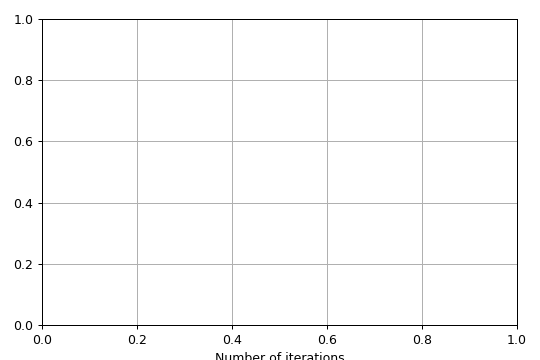

In [58]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"], max_fraction_spent_plotting=.75)

In [63]:
batch_size = 32
num_epochs = 1


for epoch_cnt in range(num_epochs):
    idxs = np.arange(len(train)) 
    np.random.shuffle(idxs)

    for batch_cnt in range(len(train) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        
        # captions
        truth_caption = train[batch_indices][0]
        #image and confusion
        truth_image = train[batch_indices][1]
        confusion = train[batch_indices][2]
        
        prediction_truth = model(truth_image)  
        prediction_confusion = model(confusion)
        
        sim_truth = np.dot(prediction_truth, truth_caption)
        sim_confusion =  np.dot(prediction_confusion, truth_caption)
        
        # add einsum 
        loss = margin_ranking_loss(sim_truth, sim_confusion, truth_caption, margin=0.25) 

        loss.backward() 

        optim.step() 

        acc = accuracy(prediction_truth, prediction_confusion, truth_caption)
        
        plotter.set_train_batch(
            {"loss": loss.item(), "accuracy": acc}, batch_size=batch_size
        )
        
    for batch_cnt in range(0, len(x_test) // batch_size):
        idxs = np.arange(len(x_test))
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size] 
        batch = x_test[batch_indices]

        with mg.no_autodiff:
            # captions
            truth_caption_ID = test[batch_indices][0]
            truth_caption = get_word_vectors(capID2cap[truth_caption_ID])
            #image and confusion
            truth_image = test[batch_indices][1]
            confusion = test[batch_indices][2]

            prediction_truth = model(truth_image)  
            prediction_confusion = model(confusion)
            
            acc = accuracy(prediction_truth, prediction_confusion, truth_caption)

        plotter.set_test_batch({"accuracy": acc}, batch_size=batch_size)

    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()

[array([239019, 213652, 261205])]


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
ids = np.array(IDs)
# only fill w validation set images to know that the quality of our results isn't overfitting on our data
imageVectors = np.array(vectors)

def query(captionVector):
    dot = np.dot(imageVectors, captionVector)
    return ids[np.argpartition(dot, -4)[-4:]]

In [ ]:
import io

import requests
from PIL import Image

def download_image(img_url: str) -> Image:
    response = requests.get(img_url)
    return Image.open(io.BytesIO(response.content))

In [ ]:
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
images = query(caption_vector)
# reading images
Image1 = coca_data[images[0]].url
Image2 = coca_data[images[1]].url
Image3 = coca_data[images[2]].url
Image4 = coca_data[images[3]].url
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Second")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Third")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Fourth")